Ebben a Demo-ban az érzelmek felismerésével ismerkedhetünk meg beszédből. Az adatbázis 38 beszélőt tartalmaz, akik magyar nyelven a "Kovács Katival szeretnék beszélni" szöveget monták be 8 érzelmi állapot imitálásával. Ezen érzelmek a szomorúság, harag, félelem, izgatottság, undor, megelettség, öröm és semeleges. Jelen esetben a jellzőkinyerést egy mély tanuló algoritmussal végezzük.

Az első lépés a *szükséges csomagok* betöltése.

In [1]:
%%capture
# Local installation
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/
!pip install -r requirements.txt
!pip install -e .

In [2]:
%%capture
# For pip installation
!pip install speechbrain

In [3]:
import os
import pandas as pd
import numpy as np
import torchaudio
import matplotlib.pyplot as plt

from speechbrain.pretrained import EncoderClassifier

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.manifold import TSNE

A jellemzőkinyerő modellt (x-vector) a SpeechBrain csomagból hívjuk meg.

In [4]:
classifier = EncoderClassifier.from_hparams(
source="speechbrain/spkrec-xvect-voxceleb", run_opts={"device":"cuda"})

Ezután az elérési utat adjuk meg az adatbázishoz. Az adatbázist szűrjük a fent leírt beszédmintákra (magyar nyelv és 1. feladat). A célcímkéket eltárolkjuk a *labels* változóban.

In [5]:
!wget http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
!unzip HungarianEmotionalSentences.zip

--2023-11-13 12:50:46--  http://lsa.tmit.bme.hu/files/HungarianEmotionalSentences.zip
Resolving lsa.tmit.bme.hu (lsa.tmit.bme.hu)... 152.66.246.99
Connecting to lsa.tmit.bme.hu (lsa.tmit.bme.hu)|152.66.246.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62600577 (60M) [application/x-zip-compressed]
Saving to: ‘HungarianEmotionalSentences.zip’

HungarianEmotionalS 100%[===================>]  59.70M  16.7MB/s    in 5.2s    

2023-11-13 12:50:53 (11.6 MB/s) - ‘HungarianEmotionalSentences.zip’ saved [62600577/62600577]

Archive:  HungarianEmotionalSentences.zip
  inflating: readme.txt              
  inflating: F0001B_hu.wav           
  inflating: F0001D_hu.wav           
  inflating: F0001I_hu.wav           
  inflating: F0001L_hu.wav           
  inflating: F0001M_hu.wav           
  inflating: F0001O_hu.wav           
  inflating: F0001S_hu.wav           
  inflating: F0002B_hu.wav           
  inflating: F0002D_hu.wav           
  inflating: F0002F_hu.wav  

In [6]:
!ls

conftest.py    F2041I_hu.wav  F3023O_hu.wav		       M0061B_hu.wav  M2091S_hu.wav
docs	       F2041L_hu.wav  F3023S_hu.wav		       M0061D_hu.wav  M2092F_hu.wav
F0001B_hu.wav  F2041M_hu.wav  F3031D_hu.wav		       M0061F_hu.wav  M2092I_hu.wav
F0001D_hu.wav  F2041O_hu.wav  F3031F_hu.wav		       M0061I_hu.wav  M2092S_hu.wav
F0001I_hu.wav  F2041S_hu.wav  F3031I_hu.wav		       M0061L_hu.wav  M2093B_hu.wav
F0001L_hu.wav  F2042B_hu.wav  F3031L_hu.wav		       M0061M_hu.wav  M2093D_hu.wav
F0001M_hu.wav  F2042D_hu.wav  F3031M_hu.wav		       M0061O_hu.wav  M2093F_hu.wav
F0001O_hu.wav  F2042I_hu.wav  F3031O_hu.wav		       M0061S_hu.wav  M2093I_hu.wav
F0001S_hu.wav  F2042L_hu.wav  F3031S_hu.wav		       M0062B_hu.wav  M2093M_hu.wav
F0002B_hu.wav  F2042O_hu.wav  F3032B_hu.wav		       M0062D_hu.wav  M2093O_hu.wav
F0002D_hu.wav  F2042S_hu.wav  F3032F_hu.wav		       M0062F_hu.wav  M2093S_hu.wav
F0002F_hu.wav  F2043B_hu.wav  F3032L_hu.wav		       M0062I_hu.wav  M4001B_hu.wav
F0002I_hu.wav  F2043D_hu.wav  F

In [7]:
DATA_PATH = "/content/speechbrain/"

file_names = sorted(i for i in os.listdir(DATA_PATH) if i.endswith("_hu.wav") and i[4] == '1')
file_paths = [os.path.join(DATA_PATH, name) for name in file_names]

labels = []
names = []

for name in file_names:
    labels.append(name.split(".")[0].split("_")[0][-1])
    names.append(name.split((".")[0].split("_")[0][-1]))

A címkék a *my_dict* szerinti egy betűs kódolásban vannak a labels *változóban*. Ezeket átalakítjuk számunkra értelmezhetőbb címkékké.

In [8]:
my_dict = {
    'B': "sadness",
    'D': "anger",
    'F': "fear",
    'I': "excitement",
    'L': "disgust",
    'M': "suprise",
    'O': "joy",
    'S': "neutral"
}

for i in range(len(labels)):
    if labels[i] in my_dict:
        labels[i] = my_dict[labels[i]]

A követkző cellában az embedding modell segítségével kinyerjük a jellemzőket. A jellemzőkinyerő algoritmus a pytorch keretrendszerben fut.

In [9]:
embeddings_list = []

for i, file_name in enumerate(file_paths):
    signal, fs = torchaudio.load(file_name)
    embeddings = classifier.encode_batch(signal)
    embeddings_list.append(embeddings.cpu().numpy())

embeddings_array = np.squeeze(np.array(embeddings_list))
print("Shape of array: ", embeddings_array.shape)

Shape of array:  (262, 512)


A kapott jellemzőket standarizáljuk (z = (x - átlag) / szórás) és eltároljuk az *X* változóban. A címkéket egy *y* tömbben tároljuk el.

In [10]:
scaler = StandardScaler()
scaler.fit(embeddings_array)
X = scaler.transform(embeddings_array)

y = np.array(labels)

Support Vektor Gép modellt fogunk taníani és tesztelni. Ehhez teljes keresztvalidációs eéjárást alkalmazunk, ahol mindig egy elem a teszt elem, a maradék pedig a tanító halmaz. Ez ismétlődik, amíg az összes elem nem volt tesztelem. Tesztelés során  a minta eredeti címkéjét (*orig*) és a bescült címkét (*pred*) eltároljuk.

In [11]:
loo = LeaveOneOut()
loo.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in enumerate(loo.split(X)):

    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVC(kernel = 'linear', probability=(False))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    orig.append(y_test[0])
    pred.append(y_pred)

Végül egy *tévesztési mátrixon* és egy *reporton* keresztül vizsgálhatjuk a modellek teljesítményét.

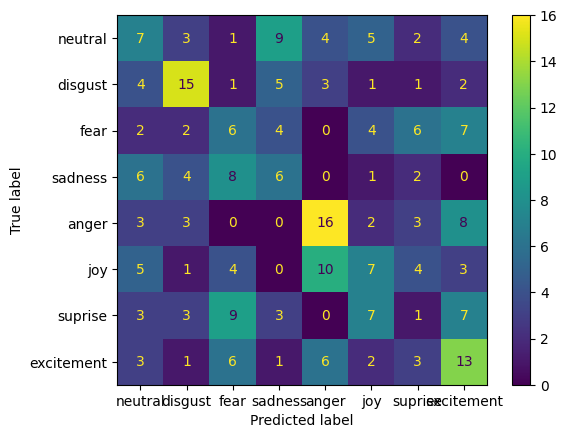

In [12]:
cm = metrics.confusion_matrix(orig, pred, labels=list(set(labels)))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(labels)))
disp.plot()
plt.show()

In [13]:
print(metrics.classification_report(orig, pred, target_names=list(set(labels))))

              precision    recall  f1-score   support

     neutral       0.41      0.46      0.43        35
     disgust       0.47      0.47      0.47        32
        fear       0.30      0.37      0.33        35
     sadness       0.17      0.19      0.18        31
       anger       0.24      0.21      0.22        34
         joy       0.21      0.20      0.21        35
     suprise       0.21      0.22      0.22        27
  excitement       0.05      0.03      0.04        33

    accuracy                           0.27       262
   macro avg       0.26      0.27      0.26       262
weighted avg       0.26      0.27      0.26       262



Vizuális betekintést tehetünk a jellemzők szeparációs képességébe úgy, hogy dimenziójukat lecsökkentjük (ábrázolható mennyiségre) a minták egymáshoz képesti távolságuk megtartása mellett (t-SNE: t-distributed stochastic neighbor embedding). Az ábrázoláshoz az érzelmeket színkódoljuk egy szótár segítségével.

(-51.146603965759276,
 53.41846599578857,
 -33.45615482330322,
 31.580300331115723)

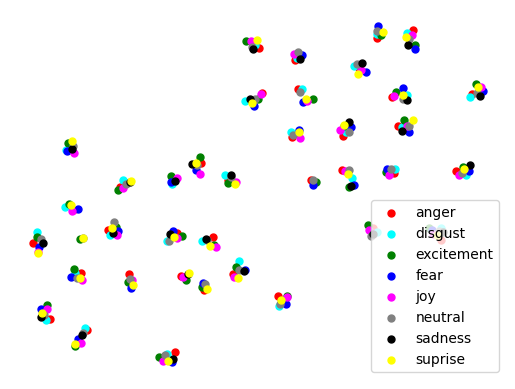

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X)

cdict = {
    "sadness": 'black',
    "anger": 'red',
    "fear": 'blue',
    "excitement": 'green',
    "disgust": 'cyan',
    "suprise": 'yellow',
    "joy": 'magenta',
    "neutral": 'gray'
}

for g in np.unique(y):
    ix = np.where(y == g)
    plt.scatter(X_embedded[ix,0], X_embedded[ix,1], c = cdict[g], label = g, s = 25)
plt.legend()
plt.axis('off')